### Description
- Investigate prediction differences between labels at time 0 and 24hr
- Only 318 observations with differences >= 0.3

Inputs:
- `1_4_cohort_diff_full_features`
- `1_4_cohort_test_results`

In [1]:
library(caret) # import this before glmnet to avoid rlang version problem
library(data.table)
library(tidyverse)
library(lubridate)
library(Matrix)
library(glmnet)
library(bit64)
library(pROC)
library(rms)

Loading required package: lattice

Loading required package: ggplot2

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::lift()      masks caret::lift()
x purrr::transpose() masks data.table::transpose()


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'Matrix'


The following 

In [2]:
# directories
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"
modeldir4 = "../../OutputTD/3_models/1_4_cohort"

In [17]:
coh_diff <- read.csv(file.path(modeldir4, '1_4_cohort_diff_full_features.csv'))
nrow(coh_diff) #71107
coh_diff <-  coh_diff %>% mutate(admit_time = ymd_hms(admit_time), time =  ymd_hms(time))
colnames(coh_diff)

coh_diff %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

[1] 71107

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time"              "first_label"            
 [5] "death_24hr_recent_label" "death_24hr_max_label"   
 [7] "pred_first"              "pred_death_24hr_recent" 
 [9] "abs_diff0_24"            "diff0_True"             
[11] "diff24_True"             "feature_type"           
[13] "features"                "values"                 
[15] "time"

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Microbiology,203
Procedures,513
Imaging,1822
demo,5406
Lab,6305
vitals,12376
Meds,12397
labs,12616
Diagnosis,19469


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



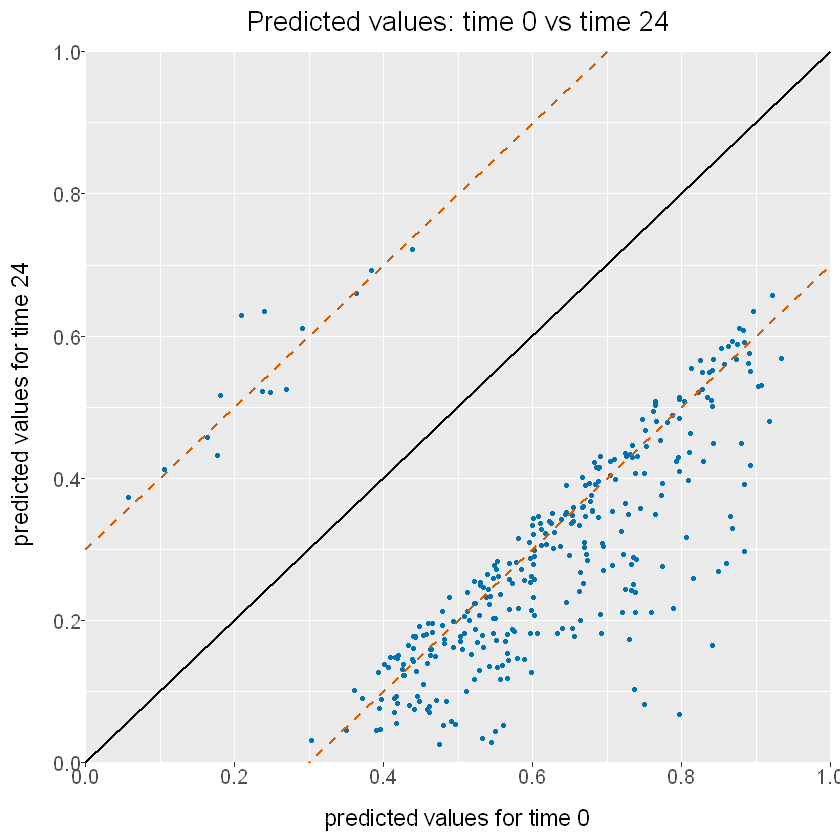

In [18]:
options(repr.plot.width=7, repr.plot.height=7)

ggplot(coh_diff, aes(x=pred_first, y=pred_death_24hr_recent)) + 
    geom_point(color = "#0072B2", size = 1) + xlim(0,1) + ylim(0,1) +
    geom_abline(intercept = 0, slope = 1, size = 0.7) +
    geom_abline(intercept = 0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    geom_abline(intercept = -0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    scale_x_continuous(name = "predicted values for time 0", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) + 
    scale_y_continuous(name = " predicted values for time 24", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) +
    theme(axis.text=element_text(size=12),
          axis.text.x = element_text(margin=margin(0, 0, 10, 0)),
          axis.text.y = element_text(margin=margin(0, 0, 0, 10)),
          plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
          axis.title=element_text(size=14)) +
     labs(title = "Predicted values: time 0 vs time 24")


### Check most difference first
- 0.7 or more: 3
- 0.6 or more: 11
- 0.5 or more: 33

In [23]:
diff <- coh_diff %>% 
            group_by(abs_diff0_24) %>% summarise(count = n()) %>% arrange(-abs_diff0_24) %>% 
            mutate(cum_count = cumsum(count), 'cumperc(%)' = round(100*cum_count/nrow(coh_diff), 2)) 

diff

`summarise()` ungrouping output (override with `.groups` argument)



abs_diff0_24,count,cum_count,cumperc(%)
<dbl>,<int>,<int>,<dbl>
0.7,561,561,0.79
0.6,1328,1889,2.66
0.5,5297,7186,10.11
0.4,19987,27173,38.21
0.3,43934,71107,100.00
